# Caso de estudio: Reconstrucción del campo de flujo en una cavidad cuadrada

**Profesores**: Dr. Ing. Benjamin A. TOURN - Ing. Carlos G. MASSOBRIO

**Cohorte**: B32025

**Grupo**: N°2

**Alumno**: Maximiliano Torti

## EDP

**Ecuaciones de Navier-Stokes incompresibles**

$$(\mathbf{u}\cdot\nabla)\mathbf{u} = -\nabla p + 1/R_e \nabla^2 \mathbf{u}, \text{ en } \Omega $$
$$\nabla \mathbf{u} = 0, \text{ en } \Omega $$

## TP N°1: Puntos de colocacion

In [19]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import cm
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from pyDOE import lhs

In [20]:
pressure_raw_data = scipy.io.loadmat('./Re-100/pressure.mat')
velocity_raw_data = scipy.io.loadmat('./Re-100/velocity.mat')

In [21]:
pressure_raw_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Apr  5 20:31:06 2023',
 '__version__': '1.0',
 '__globals__': [],
 'x': array([[0.   , 0.01 , 0.02 , ..., 0.975, 0.985, 0.995]]),
 'y': array([[0.   , 0.   , 0.   , ..., 0.995, 0.995, 0.995]]),
 'z': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'p': array([[0.00000000e+00, 1.62864847e-05, 1.31113620e-05, ...,
         1.05833522e+00, 1.66906380e+00, 3.40199098e+00]])}

In [22]:
velocity_raw_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Apr  5 20:33:39 2023',
 '__version__': '1.0',
 '__globals__': [],
 'x': array([[0.   , 0.01 , 0.02 , ..., 0.975, 0.985, 0.995]]),
 'y': array([[0.   , 0.   , 0.   , ..., 0.995, 0.995, 0.995]]),
 'z': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'u': array([[0.        , 0.        , 0.        , ..., 0.65946941, 0.49345089,
         0.17337734]]),
 'v': array([[ 0.        ,  0.        ,  0.        , ..., -0.03262434,
         -0.06381343, -0.15660411]]),
 'w': array([[0., 0., 0., ..., 0., 0., 0.]])}

### 1. Xpde y Xbc

In [23]:
# n_pde debe ser = n^2 para grilla regular
n_pde = 1024
n_bc= 100

x_lb = 0
x_ub = 1
y_lb = 0
y_ub = 1

#### Grilla regular

In [24]:
def get_xy_pde_mesh(x_bounds, y_bounds, n):
    x_step = (x_bounds[1]-x_bounds[0])/(np.sqrt(n) + 1)
    y_step = (y_bounds[1]-y_bounds[0])/(np.sqrt(n) + 1)
    x = np.arange(x_bounds[0] + x_step, x_bounds[1], x_step)
    y = np.arange(y_bounds[0]  + y_step, y_bounds[1], y_step)
    return np.array([[x_i, y_i] for x_i in x for y_i in y])

xy_pde_mesh = get_xy_pde_mesh([x_lb, x_ub], [y_lb, y_ub], n_pde)

In [25]:
def get_xy_bc_mesh(x_bounds, y_bounds, n):
    x_step = (x_bounds[1]-x_bounds[0])/(n / 4)
    y_step = (y_bounds[1]-y_bounds[0])/(n / 4)
    l1 = np.array([[x_i, y_bounds[0]] for x_i in np.arange(x_bounds[0], x_bounds[1], x_step)])
    l2 = np.array([[x_bounds[1], y_i] for y_i in np.arange(y_bounds[0], y_bounds[1], y_step)])
    l3 = np.array([[x_i, y_bounds[1]] for x_i in np.arange(x_bounds[1], x_bounds[0], -x_step)])
    l4 = np.array([[x_bounds[0], y_i] for y_i in np.arange(y_bounds[1], y_bounds[0], -y_step)])
    return np.concatenate([l1,l2,l3,l4], axis=0)

xy_bc_mesh = get_xy_bc_mesh([x_lb, x_ub], [y_lb, y_ub], n_bc)

#### Muestreo aleatorio

In [26]:
def get_xy_pde_random(x_bounds, y_bounds, n):
    x = np.random.uniform(np.nextafter(x_bounds[0], x_bounds[1]), x_bounds[1], n)
    y = np.random.uniform(np.nextafter(y_bounds[0], y_bounds[1]), y_bounds[1], n)
    return np.array([[x[i], y[i]] for i in range(n)])

xy_pde_random = get_xy_pde_random([x_lb, x_ub], [y_lb, y_ub], n_pde)

In [27]:
def get_xy_bc_random(x_bounds, y_bounds, n):
    xy = []
    for i in range(n):    
        side = random.choice(['top', 'right', 'bottom', 'left'])
        if side == 'top':
            xy.append([x_bounds[1], np.random.uniform(y_bounds[0], y_bounds[1], 1)[0]])
        elif side == 'right':
            xy.append([np.random.uniform(x_bounds[0], x_bounds[1], 1)[0], y_bounds[1]])
        elif side == 'bottom':
            xy.append([x_bounds[0], np.random.uniform(y_bounds[0], y_bounds[1], 1)[0]])
        else:  # side == 'left'
            xy.append([np.random.uniform(x_bounds[0], x_bounds[1], 1)[0], y_bounds[0]])
    return np.array(xy)

xy_bc_random = get_xy_bc_random([x_lb, x_ub], [y_lb, y_ub], n_bc)

### 2. Graficar puntos de colocación

#### Grilla regular

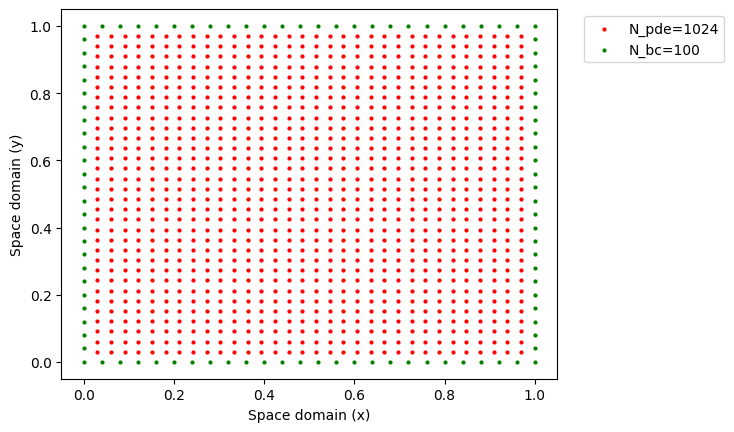

In [28]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xy_pde_mesh[:,0], xy_pde_mesh[:,1], s=4, c='r', label=f'N_pde={len(xy_pde_mesh)}')
ax.scatter(xy_bc_mesh[:,0], xy_bc_mesh[:,1], s=4, c='g', label=f'N_bc={len(xy_bc_mesh)}')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.xlabel('Space domain (x)')
plt.ylabel('Space domain (y)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

#### Muestreo aleatorio

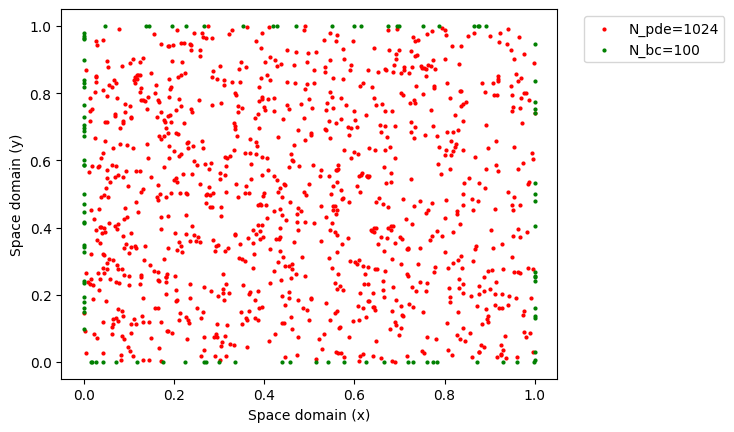

In [29]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xy_pde_random[:,0], xy_pde_random[:,1], s=4, c='r', label=f'N_pde={len(xy_pde_mesh)}')
ax.scatter(xy_bc_random[:,0], xy_bc_random[:,1], s=4, c='g', label=f'N_bc={len(xy_bc_mesh)}')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.xlabel('Space domain (x)')
plt.ylabel('Space domain (y)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

### 3. Datos rotulados

In [30]:
n_data = 10

In [31]:
def get_ds_data(pressure_ds, velocity_ds, n):
    idxs = [random.randrange(0, len(pressure_raw_data['x'][0])) for _ in range(n)]
    xy = []
    labels = []
    for idx in idxs:
        assert pressure_ds['x'][0][idx] == velocity_ds['x'][0][idx]
        assert pressure_ds['y'][0][idx] == velocity_ds['y'][0][idx]
        xy.append([pressure_ds['x'][0][idx], pressure_ds['y'][0][idx]])
        labels.append([velocity_ds['u'][0][idx], velocity_ds['v'][0][idx], pressure_ds['p'][0][idx]])
    return np.array(xy), np.array(labels)

xy_data_random, labels_data_random = get_ds_data(pressure_raw_data, velocity_raw_data, n_data)

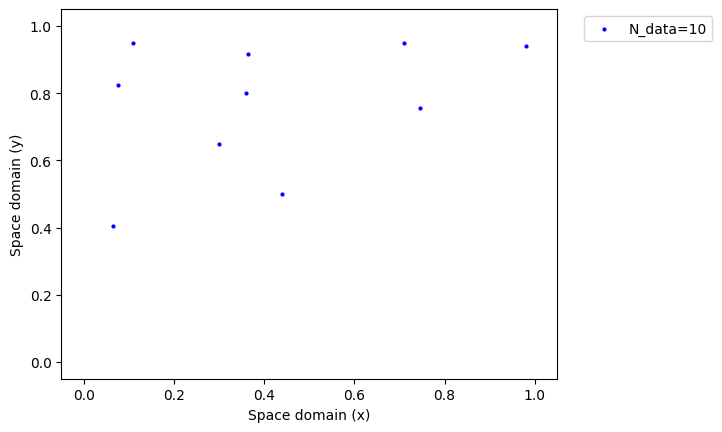

In [32]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xy_data_random[:,0], xy_data_random[:,1], s=4, c='b', label=f'N_data={len(xy_data_random)}')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.xlabel('Space domain (x)')
plt.ylabel('Space domain (y)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

Este dataset de datos rotulados contiene no solamente los valores de input (x e y) del modelo sino también los valores de las etiquetas/salidas (p, u, v), por lo que constituye un caso de entrenamiento supervisado. En cambio, los datasets de puntos de colocación contienen solamente los valores de input (x e y) del modelo, por lo que se asemejaría más a un problema no supervisado, pero en realidad lo convertimos en "supervisado" a traves del uso de las EDP.

Como la estructura del dataset de datos rotulados y la de los datasets de puntos de colocación son diferentes, no podremos concatenarlos y seleccionar aleatoriamente batch que incluyan puntos de ambos al mismo tiempo. En su lugar, tendremos que entrenar el modelo de a pasos.

### 4. Para pensar

El sub-conjunto de los puntos de colocación xy_pde no debería contener puntos sobre la frontera del dominio, ya que la definición de la PDE se hace sobre el conjunto abierto del dominio (sin incluir el borde).

## TP N°2: Modelado PINN

### 1. Rutina PINN

Las ecuaciones vectoriales de Navier-Stokes incompresibles para 2D pueden ser desarrolladas como

$$ u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y}= -\frac{\partial p}{\partial x} + 1/R_e(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}), \text{ en } \Omega $$

$$ u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}= -\frac{\partial p}{\partial y} + 1/R_e(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}), \text{ en } \Omega $$

$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0, \text{ en } \Omega $$

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [34]:
 class PINN_Module(nn.Module):

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Reynolds = model_parameters["Reynolds"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)
        self.init_xavier()
        
    def init_xavier(self):
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)
        self.apply(init_weights)

    def forward(self, x):
        output = self.ActivationFunction(self.InputLayer(x))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        return output

    def pdeResidue(self, X, output):
        # Separate output in u,v and p
        u = output[:,0:1]
        v = output[:,1:2]
        p = output[:,2:3]
        
        # Compute the derivatives of the outputs u,v and p over the inputs (x,y) using AD mechanism:
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        u_x, u_y = diff_u[:, 0:1], diff_u[:, 1:2]
        v_x, v_y = diff_v[:, 0:1], diff_v[:, 1:2]
        p_x, p_y = diff_p[:, 0:1], diff_p[:, 1:2]

        # Compute the second derivative of the outputs u and v over the inputs (x,y) using AD mechanism:
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, X, create_graph=True, grad_outputs=torch.ones_like(u_y))[0][:, 1:2]
        v_xx = torch.autograd.grad(v_x, X, create_graph=True, grad_outputs=torch.ones_like(v_x))[0][:, 0:1]
        v_yy = torch.autograd.grad(v_y, X, create_graph=True, grad_outputs=torch.ones_like(v_y))[0][:, 1:2]
        
        # Compute residues
        residue_continuity = u_x + v_y
        residue_momentum_x = u * u_x + v * u_y + p_x - self.Reynolds * (u_xx + u_yy)
        residue_momentum_y = u * v_x + v * v_y + p_y - self.Reynolds * (v_xx + v_yy)
        return torch.cat([residue_continuity, residue_momentum_x, residue_momentum_y], axis=1)

    def bcUVResidue(self, X, output):
        # Separate u and v from the output
        u = output[:,0:1]
        v = output[:,1:2]
        # Calculate true bc values 
        u_bc = (X[:,1:2] == 1) * 1.0 # u = 1 only at upper y bound, else 0
        residue_u = u - u_bc
        residue_v = v # v = 0 on all border
        return torch.cat([residue_u, residue_v], axis=1)

    def bcPResidue(self, X, output):
        # Separate p from the output
        p = output[:,2:3]
        residue_p = p # p = 0 on the origin
        return residue_p

### 2. Resolver PINN

In [35]:
model_parameters = {
    "Reynolds": 1/100,
    "InputDimensions": 2,
    "OutputDimensions": 3,
    "NumberOfNeurons": 50,
    "NumberOfHiddenLayers": 8,
    "ActivationFunction": nn.Tanh()
}

In [19]:
model = PINN_Module(model_parameters).to(device)
epochs = 15000
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Initialization of data structures
xy_pde_random = get_xy_pde_random([x_lb, x_ub], [y_lb, y_ub], 10_000)
X_pde = torch.tensor(xy_pde_random, requires_grad = True).float().to(device)
xy_bc_random = get_xy_bc_random([x_lb, x_ub], [y_lb, y_ub], 1_000)
X_bc = torch.tensor(xy_bc_random).float().to(device)
X_bc_0 = torch.tensor([[0, 0]]).float().to(device)

loss_train = {'Overall' : [], 'PDE': [], 'BC_UV': [], 'BC_P': []}

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()

    # PDE
    output_pde = model(X_pde)
    y_hat_pde = model.pdeResidue(X_pde, output_pde)
    loss_pde = loss_fn(y_hat_pde, torch.zeros_like(y_hat_pde))
    
    # BC u,v
    output_bc = model(X_bc)
    y_hat_uv = model.bcUVResidue(X_bc, output_bc)
    loss_bc_uv = loss_fn(y_hat_uv, torch.zeros_like(y_hat_uv))
    # BC P
    output_bc_0 = model(X_bc_0)
    y_hat_p = model.bcPResidue(X_bc_0, output_bc_0)
    loss_bc_p = loss_fn(y_hat_p, torch.zeros_like(y_hat_p))

    # Loss, backpropagation and gradient descent
    loss_overall = loss_pde + loss_bc_uv + loss_bc_p
    loss_overall.backward()
    optimizer.step()

    # Log
    loss_train['Overall'].append(loss_overall.item())
    loss_train['PDE'].append(loss_pde.item())
    loss_train['BC_UV'].append(loss_bc_uv.item())
    loss_train['BC_P'].append(loss_bc_p.item())
    if (epoch+1) % 100 == 0:
        tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                   f"PDE: {loss_pde.item():.4e}, BC_UV: {loss_bc_uv.item():.4e}, "
                   f"BC_P: {loss_bc_p.item():.4e}")

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 100/15000 - Loss Overall: 4.3482e-02, PDE: 6.1871e-03, BC_UV: 3.7295e-02, BC_P: 1.6037e-07
Epoch 200/15000 - Loss Overall: 3.1611e-02, PDE: 3.7128e-03, BC_UV: 2.7898e-02, BC_P: 1.7397e-07
Epoch 300/15000 - Loss Overall: 2.5878e-02, PDE: 2.4429e-03, BC_UV: 2.3435e-02, BC_P: 5.9960e-08
Epoch 400/15000 - Loss Overall: 2.2166e-02, PDE: 1.8666e-03, BC_UV: 2.0299e-02, BC_P: 2.2027e-08
Epoch 500/15000 - Loss Overall: 1.9398e-02, PDE: 1.5450e-03, BC_UV: 1.7853e-02, BC_P: 1.4433e-08
Epoch 600/15000 - Loss Overall: 1.7247e-02, PDE: 1.3642e-03, BC_UV: 1.5883e-02, BC_P: 8.4306e-09
Epoch 700/15000 - Loss Overall: 1.5538e-02, PDE: 1.2635e-03, BC_UV: 1.4274e-02, BC_P: 4.9924e-09
Epoch 800/15000 - Loss Overall: 1.4110e-02, PDE: 1.1991e-03, BC_UV: 1.2911e-02, BC_P: 4.2478e-09
Epoch 900/15000 - Loss Overall: 1.2874e-02, PDE: 1.1498e-03, BC_UV: 1.1724e-02, BC_P: 4.6186e-09
Epoch 1000/15000 - Loss Overall: 1.1831e-02, PDE: 1.1133e-03, BC_UV: 1.0718e-02, BC_P: 4.3965e-09
Epoch 1100/15000 - Loss Overa

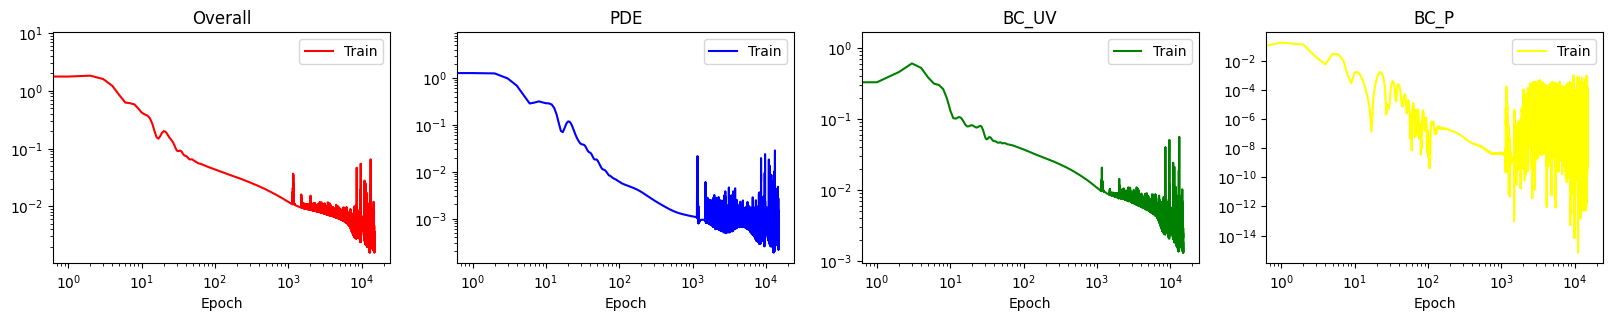

In [20]:
# Evolution of the loss function
colors = ['red', 'blue', 'green', 'yellow']
# Overall
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
for i, loss_type in enumerate(['Overall', 'PDE', 'BC_UV', 'BC_P']):
    epoch_train = np.arange(0, len(loss_train[loss_type]))
    ax[i].loglog(epoch_train, loss_train[loss_type], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(loss_type)
    ax[i].legend()
plt.show()

In [21]:
torch.save(model.state_dict(), "./model.pt")

### 3. Calculo de error

In [23]:
xy_data_all = np.concatenate([pressure_raw_data['x'][0][:,np.newaxis], pressure_raw_data['y'][0][:,np.newaxis]], axis=1)
labels_data_all = np.concatenate([velocity_raw_data['u'][0][:,np.newaxis],velocity_raw_data['v'][0][:,np.newaxis],
                                 pressure_raw_data['p'][0][:,np.newaxis]], axis=1)

In [24]:
model.train(False)
with torch.no_grad():
    X_data = torch.tensor(xy_data_all).float().to(device)
    output_data = model(X_data).cpu().numpy()

In [25]:
mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
print(f"Normal 2  del error (ECM) en u: {mse_u}, v: {mse_v}, p: {mse_p}")

Normal 2  del error (ECM) en u: 0.0016489706053349376, v: 0.003423259063144708, p: 0.0037767610396114114


### 4. Gráficas

#### Campos de predicción de velocidades y presión

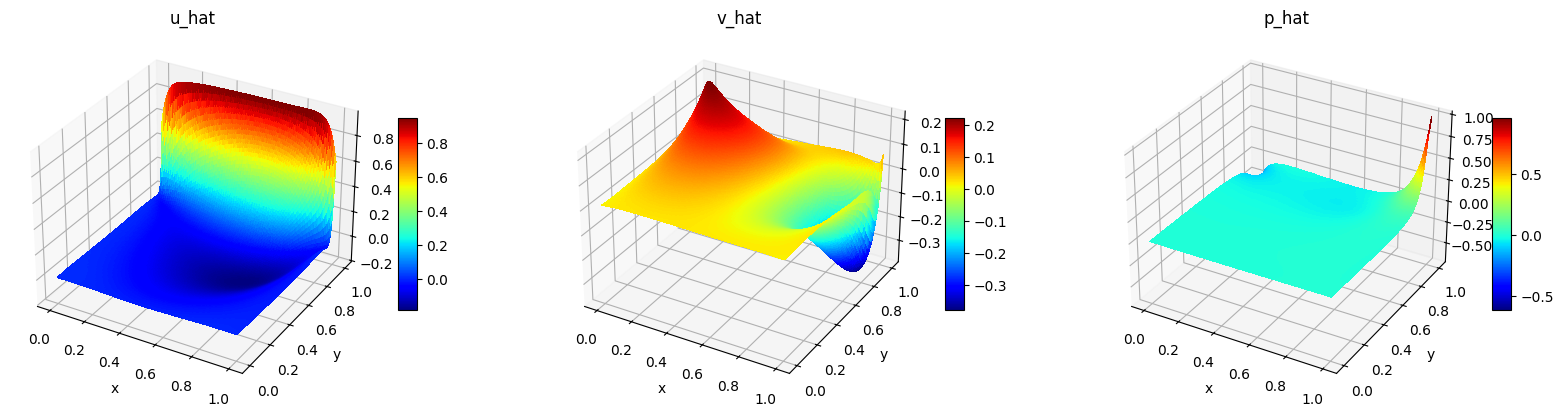

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection='3d'))
# u graph
ax = axs[0]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,0], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('u_hat')

# v graph
ax = axs[1]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,1], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('v_hat')

# p graph
ax = axs[2]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,2], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('p_hat')
plt.show()

#### Campos reales de velocidades y presión

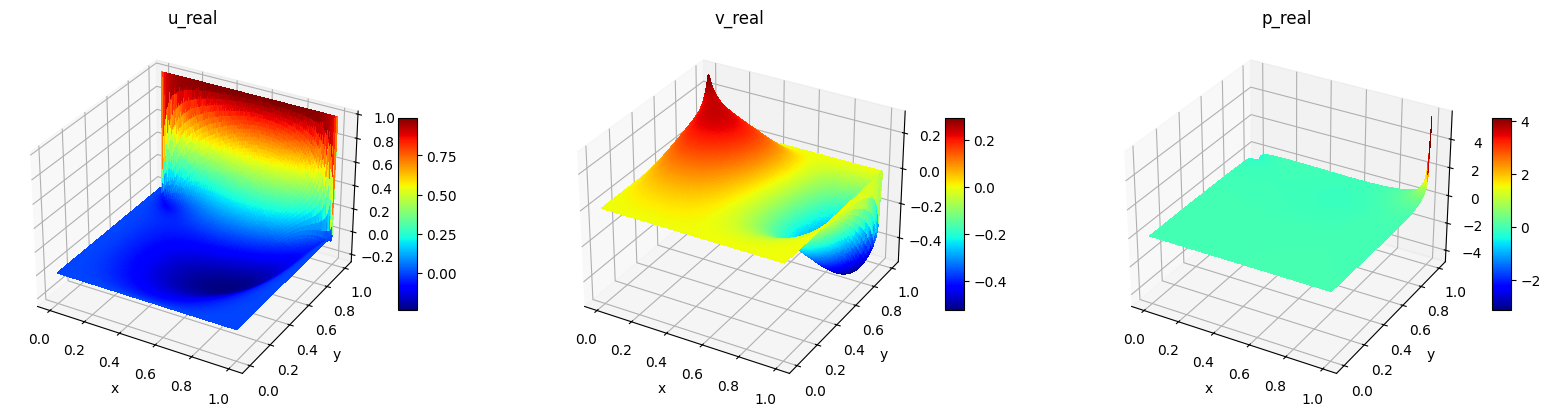

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection='3d'))
# u graph
ax = axs[0]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], labels_data_all[:,0], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('u_real')

# v graph
ax = axs[1]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], labels_data_all[:,1], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('v_real')

# p graph
ax = axs[2]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], labels_data_all[:,2], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('p_real')
plt.show()

#### Gráficas error absoluto

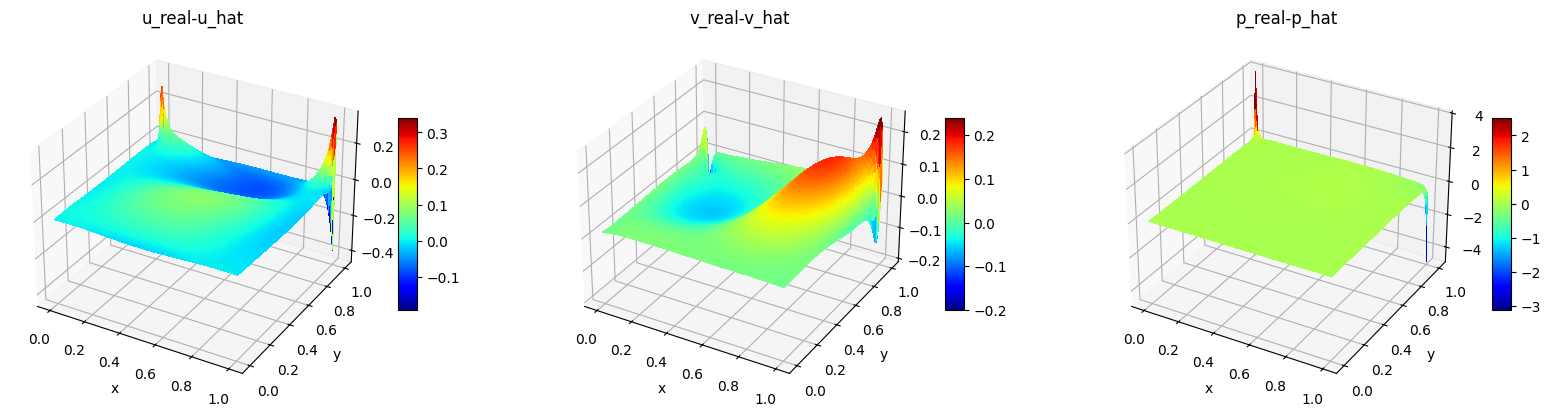

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection='3d'))
# u graph
ax = axs[0]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,0]-labels_data_all[:,0], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('u_real-u_hat')

# v graph
ax = axs[1]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,1]-labels_data_all[:,1], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('v_real-v_hat')

# p graph
ax = axs[2]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,2]-labels_data_all[:,2], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('p_real-p_hat')
plt.show()

#### Gráficas perfiles

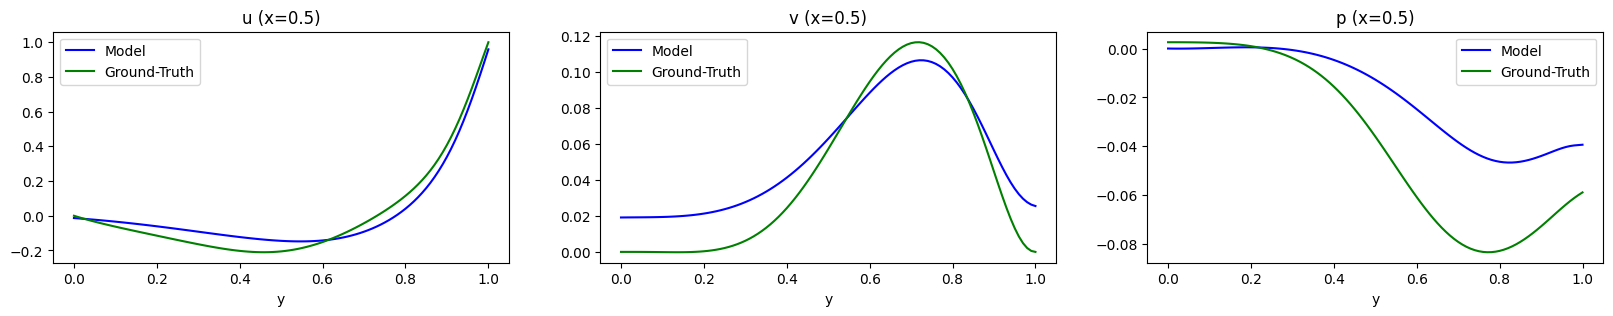

In [30]:
# Grafica sobre x=0.5
mask_x05 = np.where(xy_data_all[:, 0] == 0.5)
xy_data_x05 = xy_data_all[mask_x05]
labels_data_x05 = labels_data_all[mask_x05]

model.train(False)
with torch.no_grad():
    X_data = torch.tensor(xy_data_x05).float().to(device)
    output_data = model(X_data).cpu().numpy()

fig, ax = plt.subplots(1, 3, figsize=(20, 3))
for i, title in enumerate(['u', 'v', 'p']):
    epoch_train = np.arange(0, len(loss_train[loss_type]))
    ax[i].plot(xy_data_x05[:,1], output_data[:,i], color='blue', label='Model')
    ax[i].plot(xy_data_x05[:,1], labels_data_x05[:,i], color='green', label='Ground-Truth')
    ax[i].set_xlabel('y')
    ax[i].set_title(f"{title} (x=0.5)")
    ax[i].legend()
plt.show()

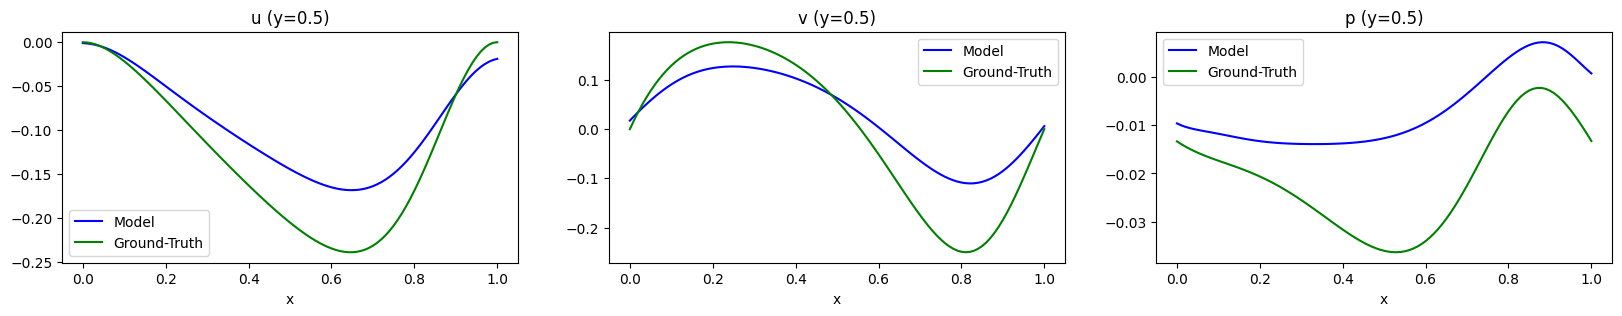

In [31]:
# Grafica sobre x=0.5
mask_y05 = np.where(xy_data_all[:, 1] == 0.5)
xy_data_y05 = xy_data_all[mask_y05]
labels_data_y05 = labels_data_all[mask_y05]

model.train(False)
with torch.no_grad():
    X_data = torch.tensor(xy_data_y05).float().to(device)
    output_data = model(X_data).cpu().numpy()

fig, ax = plt.subplots(1, 3, figsize=(20, 3))
for i, title in enumerate(['u', 'v', 'p']):
    epoch_train = np.arange(0, len(loss_train[loss_type]))
    ax[i].plot(xy_data_y05[:,0], output_data[:,i], color='blue', label='Model')
    ax[i].plot(xy_data_y05[:,0], labels_data_y05[:,i], color='green', label='Ground-Truth')
    ax[i].set_xlabel('x')
    ax[i].set_title(f"{title} (y=0.5)")
    ax[i].legend()
plt.show()

### 5. Analisis

De acuerdo a lo observado, el modelo aproxima basatante bien los campos de presión y velocidad.

En la evolución de la pérdida, se observa que todas las componente decrecen a medida que pasan las epochs. Al finalizar el entrenamiento, se obserba que la pérdida sobre la PDE se encuentra casi un orden de magnitud por debajo del residuo de la condición de borde.

De las gráficas del error absoluto se obserba que el mayor error se encuentra en las zona de mayor variación de los campos. Al graficar los perfiles u,v y p para x=0.5 e y=0.5 tanto para el modelo como para el ground-truth, observamos que el modelo tiende a suavizar los campos.

Considero que los hiperparámetros seleccionados son correctos, y que una optimización de los mismos solo produciría mejoras márginales.

Para mejorar el desempeño podríamos por ejemplo reemplazar la arquitectura por una implementación "hard" de las condiciones de borde. Por otro lado, también podríamos utilizar una mejor estrategia al conjugar todos los residuos.

## TP N°3: Estrategias de muestreo de puntos de colocación

In [36]:
# Shared model parameters
model_parameters = {
    "Reynolds": 1/100,
    "InputDimensions": 2,
    "OutputDimensions": 3,
    "NumberOfNeurons": 50,
    "NumberOfHiddenLayers": 4,
    "ActivationFunction": nn.Tanh()
}
n_datasets = [(1000, 100), (10000, 1000), (100000, 10000)]
epochs = 10000
lr = 1e-3

# Shared ground truth
xy_data_all = np.concatenate([pressure_raw_data['x'][0][:,np.newaxis], pressure_raw_data['y'][0][:,np.newaxis]], axis=1)
labels_data_all = np.concatenate([velocity_raw_data['u'][0][:,np.newaxis],velocity_raw_data['v'][0][:,np.newaxis],
                                 pressure_raw_data['p'][0][:,np.newaxis]], axis=1)

In [37]:
def train_step(model, loss_fn, X_pde, X_bc, X_bc_0):
    # PDE
    output_pde = model(X_pde)
    y_hat_pde = model.pdeResidue(X_pde, output_pde)
    loss_pde = loss_fn(y_hat_pde, torch.zeros_like(y_hat_pde))
    # BC u,v
    output_bc = model(X_bc)
    y_hat_uv = model.bcUVResidue(X_bc, output_bc)
    loss_bc_uv = 10 * loss_fn(y_hat_uv, torch.zeros_like(y_hat_uv))
    # BC P
    output_bc_0 = model(X_bc_0)
    y_hat_p = model.bcPResidue(X_bc_0, output_bc_0)
    loss_bc_p = loss_fn(y_hat_p, torch.zeros_like(y_hat_p))
    return loss_pde, loss_bc_uv, loss_bc_p

### Muestreo aleatorio uniforme

In [38]:
rand_mse_error = []

print("Random Sample Dataset Train")
for n_pde, n_bc in n_datasets:
    # Init
    model = PINN_Module(model_parameters).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    xy_pde_random = get_xy_pde_random([x_lb, x_ub], [y_lb, y_ub], n_pde)
    X_pde = torch.tensor(xy_pde_random, requires_grad = True).float().to(device)
    xy_bc_random = get_xy_bc_random([x_lb, x_ub], [y_lb, y_ub], n_bc)
    X_bc = torch.tensor(xy_bc_random).float().to(device)
    X_bc_0 = torch.tensor([[0, 0]]).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Npde = {n_pde} | Nbc = {n_bc}")
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss_pde, loss_bc_uv, loss_bc_p = train_step(model, loss_fn, X_pde, X_bc, X_bc_0)
        loss_overall = loss_pde + loss_bc_uv + loss_bc_p
        loss_overall.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                       f"PDE: {loss_pde.item():.4e}, BC_UV: {loss_bc_uv.item():.4e}, "
                       f"BC_P: {loss_bc_p.item():.4e}")

    # Calculate error
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    rand_mse_error.append({'mse_u': mse_u, 'mse_v': mse_v, 'mse_p': mse_p})
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")

Random Sample Dataset Train
------------------------------------------------------------
Npde = 1000 | Nbc = 100


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 2.5727e-01, PDE: 3.3937e-02, BC_UV: 2.2332e-01, BC_P: 1.7101e-05
Epoch 200/10000 - Loss Overall: 1.9769e-01, PDE: 1.8339e-02, BC_UV: 1.7935e-01, BC_P: 3.6217e-07
Epoch 300/10000 - Loss Overall: 1.7482e-01, PDE: 1.5976e-02, BC_UV: 1.5884e-01, BC_P: 3.6069e-08
Epoch 400/10000 - Loss Overall: 1.5961e-01, PDE: 1.3978e-02, BC_UV: 1.4563e-01, BC_P: 1.1763e-07
Epoch 500/10000 - Loss Overall: 1.4816e-01, PDE: 1.2580e-02, BC_UV: 1.3558e-01, BC_P: 9.8484e-08
Epoch 600/10000 - Loss Overall: 1.3955e-01, PDE: 1.1505e-02, BC_UV: 1.2804e-01, BC_P: 6.2689e-08
Epoch 700/10000 - Loss Overall: 1.3277e-01, PDE: 1.0408e-02, BC_UV: 1.2236e-01, BC_P: 2.4133e-08
Epoch 800/10000 - Loss Overall: 1.2711e-01, PDE: 9.3440e-03, BC_UV: 1.1777e-01, BC_P: 2.9503e-09
Epoch 900/10000 - Loss Overall: 1.2210e-01, PDE: 8.4322e-03, BC_UV: 1.1367e-01, BC_P: 6.1945e-10
Epoch 1000/10000 - Loss Overall: 1.1746e-01, PDE: 7.7146e-03, BC_UV: 1.0975e-01, BC_P: 4.0530e-09
Epoch 1100/10000 - Loss Overa

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 2.5406e-01, PDE: 3.7120e-02, BC_UV: 2.1690e-01, BC_P: 4.0306e-05
Epoch 200/10000 - Loss Overall: 2.0952e-01, PDE: 2.8331e-02, BC_UV: 1.8118e-01, BC_P: 3.6370e-06
Epoch 300/10000 - Loss Overall: 1.8318e-01, PDE: 2.1823e-02, BC_UV: 1.6136e-01, BC_P: 7.4089e-07
Epoch 400/10000 - Loss Overall: 1.6528e-01, PDE: 1.7988e-02, BC_UV: 1.4730e-01, BC_P: 1.6952e-08
Epoch 500/10000 - Loss Overall: 1.5185e-01, PDE: 1.5008e-02, BC_UV: 1.3684e-01, BC_P: 1.4919e-08
Epoch 600/10000 - Loss Overall: 1.4094e-01, PDE: 1.2775e-02, BC_UV: 1.2817e-01, BC_P: 1.4947e-09
Epoch 700/10000 - Loss Overall: 1.3177e-01, PDE: 1.1032e-02, BC_UV: 1.2073e-01, BC_P: 4.0681e-09
Epoch 800/10000 - Loss Overall: 1.2260e-01, PDE: 9.8817e-03, BC_UV: 1.1272e-01, BC_P: 1.2814e-09
Epoch 900/10000 - Loss Overall: 1.1311e-01, PDE: 8.6109e-03, BC_UV: 1.0450e-01, BC_P: 2.3781e-08
Epoch 1000/10000 - Loss Overall: 1.0355e-01, PDE: 7.7268e-03, BC_UV: 9.5826e-02, BC_P: 2.0230e-08
Epoch 1100/10000 - Loss Overa

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 3.5923e-01, PDE: 5.3679e-02, BC_UV: 3.0548e-01, BC_P: 7.5637e-05
Epoch 200/10000 - Loss Overall: 2.6034e-01, PDE: 3.8742e-02, BC_UV: 2.2159e-01, BC_P: 2.0146e-06
Epoch 300/10000 - Loss Overall: 2.2392e-01, PDE: 3.1142e-02, BC_UV: 1.9278e-01, BC_P: 1.2246e-08
Epoch 400/10000 - Loss Overall: 2.0044e-01, PDE: 2.6175e-02, BC_UV: 1.7426e-01, BC_P: 1.6496e-07
Epoch 500/10000 - Loss Overall: 1.8380e-01, PDE: 2.2983e-02, BC_UV: 1.6082e-01, BC_P: 2.3466e-07
Epoch 600/10000 - Loss Overall: 1.6971e-01, PDE: 2.0425e-02, BC_UV: 1.4929e-01, BC_P: 1.5283e-07
Epoch 700/10000 - Loss Overall: 1.5726e-01, PDE: 1.7891e-02, BC_UV: 1.3937e-01, BC_P: 1.8811e-08
Epoch 800/10000 - Loss Overall: 1.4735e-01, PDE: 1.5416e-02, BC_UV: 1.3194e-01, BC_P: 1.2942e-08
Epoch 900/10000 - Loss Overall: 1.3930e-01, PDE: 1.3247e-02, BC_UV: 1.2605e-01, BC_P: 1.3453e-08
Epoch 1000/10000 - Loss Overall: 1.3204e-01, PDE: 1.1728e-02, BC_UV: 1.2031e-01, BC_P: 1.1006e-08
Epoch 1100/10000 - Loss Overa

### Hipercubo Latino (LHS)

In [39]:
def get_xy_pde_lhs(x_bounds, y_bounds, n):
    x = x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, n)[:,0]
    y = y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, n)[:,0]
    return np.array([[x[i], y[i]] for i in range(n)])

In [40]:
def get_xy_bc_lhs(x_bounds, y_bounds, n):
    xy = []
    for i in range(n):    
        side = random.choice(['top', 'right', 'bottom', 'left'])
        if side == 'top':
            xy.append([x_bounds[1], y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, 1)[0,0]])
        elif side == 'right':
            xy.append([x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, 1)[0,0], y_bounds[1]])
        elif side == 'bottom':
            xy.append([x_bounds[0], y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, 1)[0,0]])
        else:  # side == 'left'
            xy.append([x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, 1)[0,0], y_bounds[0]])
    return np.array(xy)

In [42]:
lhs_mse_error = []

print("Latin hypercube sampling Dataset Train")
for n_pde, n_bc in n_datasets:
    # Init
    model = PINN_Module(model_parameters).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    xy_pde_lhs = get_xy_pde_lhs([x_lb, x_ub], [y_lb, y_ub], n_pde)
    X_pde = torch.tensor(xy_pde_lhs, requires_grad = True).float().to(device)
    xy_bc_lhs = get_xy_bc_lhs([x_lb, x_ub], [y_lb, y_ub], n_bc)
    X_bc = torch.tensor(xy_bc_lhs).float().to(device)
    X_bc_0 = torch.tensor([[0, 0]]).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Npde = {n_pde} | Nbc = {n_bc}")
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss_pde, loss_bc_uv, loss_bc_p = train_step(model, loss_fn, X_pde, X_bc, X_bc_0)
        loss_overall = loss_pde + loss_bc_uv + loss_bc_p
        loss_overall.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                       f"PDE: {loss_pde.item():.4e}, BC_UV: {loss_bc_uv.item():.4e}, "
                       f"BC_P: {loss_bc_p.item():.4e}")

    # Calculate error
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    lhs_mse_error.append({'mse_u': mse_u, 'mse_v': mse_v, 'mse_p': mse_p})
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")

Latin hypercube sampling Dataset Train
------------------------------------------------------------
Npde = 1000 | Nbc = 100


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 2.9790e-01, PDE: 3.4879e-02, BC_UV: 2.6301e-01, BC_P: 1.3959e-05
Epoch 200/10000 - Loss Overall: 2.3310e-01, PDE: 2.6673e-02, BC_UV: 2.0642e-01, BC_P: 8.3670e-06
Epoch 300/10000 - Loss Overall: 2.0410e-01, PDE: 2.2794e-02, BC_UV: 1.8130e-01, BC_P: 5.6083e-07
Epoch 400/10000 - Loss Overall: 1.8376e-01, PDE: 2.0168e-02, BC_UV: 1.6359e-01, BC_P: 6.8886e-08
Epoch 500/10000 - Loss Overall: 1.6753e-01, PDE: 1.7509e-02, BC_UV: 1.5002e-01, BC_P: 6.5733e-08
Epoch 600/10000 - Loss Overall: 1.5473e-01, PDE: 1.4949e-02, BC_UV: 1.3978e-01, BC_P: 2.2292e-08
Epoch 700/10000 - Loss Overall: 1.4492e-01, PDE: 1.2853e-02, BC_UV: 1.3207e-01, BC_P: 3.7179e-08
Epoch 800/10000 - Loss Overall: 1.3631e-01, PDE: 1.1245e-02, BC_UV: 1.2506e-01, BC_P: 4.6523e-08
Epoch 900/10000 - Loss Overall: 1.2879e-01, PDE: 1.0116e-02, BC_UV: 1.1868e-01, BC_P: 3.6715e-08
Epoch 1000/10000 - Loss Overall: 1.2129e-01, PDE: 9.2882e-03, BC_UV: 1.1200e-01, BC_P: 9.5157e-08
Epoch 1100/10000 - Loss Overa

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 3.0056e-01, PDE: 4.6302e-02, BC_UV: 2.5424e-01, BC_P: 1.5901e-05
Epoch 200/10000 - Loss Overall: 2.4435e-01, PDE: 3.1808e-02, BC_UV: 2.1253e-01, BC_P: 1.4315e-05
Epoch 300/10000 - Loss Overall: 2.1704e-01, PDE: 2.6466e-02, BC_UV: 1.9057e-01, BC_P: 7.1211e-06
Epoch 400/10000 - Loss Overall: 1.9557e-01, PDE: 2.2840e-02, BC_UV: 1.7273e-01, BC_P: 3.6785e-06
Epoch 500/10000 - Loss Overall: 1.7784e-01, PDE: 2.0134e-02, BC_UV: 1.5770e-01, BC_P: 2.3730e-06
Epoch 600/10000 - Loss Overall: 1.6329e-01, PDE: 1.8125e-02, BC_UV: 1.4516e-01, BC_P: 1.4349e-06
Epoch 700/10000 - Loss Overall: 1.5107e-01, PDE: 1.6385e-02, BC_UV: 1.3469e-01, BC_P: 8.2191e-07
Epoch 800/10000 - Loss Overall: 1.4126e-01, PDE: 1.4799e-02, BC_UV: 1.2646e-01, BC_P: 7.1174e-07
Epoch 900/10000 - Loss Overall: 1.3406e-01, PDE: 1.3438e-02, BC_UV: 1.2062e-01, BC_P: 7.3306e-07
Epoch 1000/10000 - Loss Overall: 1.2897e-01, PDE: 1.2377e-02, BC_UV: 1.1659e-01, BC_P: 6.6648e-07
Epoch 1100/10000 - Loss Overa

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 2.7631e-01, PDE: 4.5562e-02, BC_UV: 2.3073e-01, BC_P: 1.8912e-05
Epoch 200/10000 - Loss Overall: 2.1131e-01, PDE: 2.6291e-02, BC_UV: 1.8501e-01, BC_P: 7.1596e-07
Epoch 300/10000 - Loss Overall: 1.8964e-01, PDE: 2.2069e-02, BC_UV: 1.6757e-01, BC_P: 1.0966e-07
Epoch 400/10000 - Loss Overall: 1.7212e-01, PDE: 1.8673e-02, BC_UV: 1.5345e-01, BC_P: 1.0669e-09
Epoch 500/10000 - Loss Overall: 1.5805e-01, PDE: 1.6517e-02, BC_UV: 1.4154e-01, BC_P: 2.8352e-08
Epoch 600/10000 - Loss Overall: 1.4585e-01, PDE: 1.4465e-02, BC_UV: 1.3138e-01, BC_P: 3.7052e-08
Epoch 700/10000 - Loss Overall: 1.3549e-01, PDE: 1.2920e-02, BC_UV: 1.2257e-01, BC_P: 5.0634e-07
Epoch 800/10000 - Loss Overall: 1.2694e-01, PDE: 1.1770e-02, BC_UV: 1.1517e-01, BC_P: 8.0409e-07
Epoch 900/10000 - Loss Overall: 1.1917e-01, PDE: 1.0600e-02, BC_UV: 1.0857e-01, BC_P: 5.3035e-07
Epoch 1000/10000 - Loss Overall: 1.1185e-01, PDE: 9.6779e-03, BC_UV: 1.0218e-01, BC_P: 1.8424e-07
Epoch 1100/10000 - Loss Overa

### Muestreo adaptativo basado en residuos (RAD)

In [76]:
def get_xy_pde_rad(x_bounds, y_bounds, n, model, k=1, c=1, oversampling = 5):
    xy_pde_base = get_xy_pde_random(x_bounds, y_bounds, n * oversampling)
    X_pde_base = torch.tensor(xy_pde_base, requires_grad = True).float().to(device)
    output_pde = model(X_pde_base)
    y_hat_pde = model.pdeResidue(X_pde_base, output_pde)
    epsilon = torch.sum(torch.pow(torch.abs(y_hat_pde[:,0:2]), k), axis=1)
    err_eq = epsilon/epsilon.mean() + c
    err_eq_normalized = (err_eq/sum(err_eq))
    idx = np.random.choice(a=len(X_pde_base), size=n, replace=False, p=err_eq_normalized.data.cpu().detach().numpy())
    return X_pde_base[idx.flatten(), :].cpu().detach().numpy()

In [77]:
def get_xy_bc_rad(x_bounds, y_bounds, n, model, k=1, c=1, oversampling = 5):
    xy_bc_base = get_xy_bc_random(x_bounds, y_bounds, n * oversampling)
    X_bc_base = torch.tensor(xy_bc_base).float().to(device)
    output_bc = model(X_bc_base)
    y_hat_bc = model.bcUVResidue(X_bc_base, output_bc)
    epsilon = torch.sum(torch.pow(torch.abs(y_hat_bc), k), axis=1)
    err_eq = epsilon/epsilon.mean() + c
    err_eq_normalized = (err_eq/sum(err_eq))
    idx = np.random.choice(a=len(X_bc_base), size=n, replace=False, p=err_eq_normalized.data.cpu().detach().numpy())
    return X_bc_base[idx.flatten(), :].cpu().detach().numpy()

In [78]:
rad_mse_error = []

print("Residual-based Adaptative Distribution sampling Dataset Train")
for n_pde, n_bc in n_datasets:
    # Init
    model = PINN_Module(model_parameters).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    xy_pde_random = get_xy_pde_random([x_lb, x_ub], [y_lb, y_ub], n_pde)
    X_pde = torch.tensor(xy_pde_random, requires_grad = True).float().to(device)
    xy_bc_random = get_xy_bc_random([x_lb, x_ub], [y_lb, y_ub], n_bc)
    X_bc = torch.tensor(xy_bc_random).float().to(device)
    X_bc_0 = torch.tensor([[0, 0]]).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Npde = {n_pde} | Nbc = {n_bc}")
    for epoch in tqdm(range(epochs)):
        # RAD strategy
        if epoch % (epochs/10) == 0 and epoch!=0:
            xy_pde_rad = get_xy_pde_rad([x_lb, x_ub], [y_lb, y_ub], n_pde, model)
            X_pde = torch.tensor(xy_pde_rad, requires_grad = True).float().to(device)
            xy_bc_rad = get_xy_bc_rad([x_lb, x_ub], [y_lb, y_ub], n_bc, model)
            X_bc = torch.tensor(xy_bc_rad).float().to(device)
            tqdm.write(f"New dataset sampling based on RAD strategy")
        
        optimizer.zero_grad()
        loss_pde, loss_bc_uv, loss_bc_p = train_step(model, loss_fn, X_pde, X_bc, X_bc_0)
        loss_overall = loss_pde + loss_bc_uv + loss_bc_p
        loss_overall.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                       f"PDE: {loss_pde.item():.4e}, BC_UV: {loss_bc_uv.item():.4e}, "
                       f"BC_P: {loss_bc_p.item():.4e}")

    # Calculate error
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    rad_mse_error.append({'mse_u': mse_u, 'mse_v': mse_v, 'mse_p': mse_p})
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")

Residual-based Adaptative Distribution sampling Dataset Train
------------------------------------------------------------
Npde = 1000 | Nbc = 100


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 2.2070e-01, PDE: 2.8391e-02, BC_UV: 1.9228e-01, BC_P: 3.9001e-05
Epoch 200/10000 - Loss Overall: 1.7549e-01, PDE: 1.5750e-02, BC_UV: 1.5974e-01, BC_P: 4.1481e-08
Epoch 300/10000 - Loss Overall: 1.5869e-01, PDE: 1.2276e-02, BC_UV: 1.4642e-01, BC_P: 1.1410e-06
Epoch 400/10000 - Loss Overall: 1.4944e-01, PDE: 1.0428e-02, BC_UV: 1.3901e-01, BC_P: 8.2279e-07
Epoch 500/10000 - Loss Overall: 1.4245e-01, PDE: 9.2644e-03, BC_UV: 1.3318e-01, BC_P: 4.2134e-07
Epoch 600/10000 - Loss Overall: 1.3623e-01, PDE: 8.5070e-03, BC_UV: 1.2773e-01, BC_P: 2.5744e-07
Epoch 700/10000 - Loss Overall: 1.3034e-01, PDE: 7.9679e-03, BC_UV: 1.2237e-01, BC_P: 1.9075e-07
Epoch 800/10000 - Loss Overall: 1.2457e-01, PDE: 7.5587e-03, BC_UV: 1.1701e-01, BC_P: 1.5484e-07
Epoch 900/10000 - Loss Overall: 1.1878e-01, PDE: 7.2288e-03, BC_UV: 1.1155e-01, BC_P: 1.2409e-07
Epoch 1000/10000 - Loss Overall: 1.1284e-01, PDE: 6.9300e-03, BC_UV: 1.0591e-01, BC_P: 8.1388e-08
New dataset sampling based on

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 3.0249e-01, PDE: 5.7167e-02, BC_UV: 2.4531e-01, BC_P: 1.2910e-05
Epoch 200/10000 - Loss Overall: 2.4041e-01, PDE: 4.0807e-02, BC_UV: 1.9960e-01, BC_P: 1.0674e-06
Epoch 300/10000 - Loss Overall: 2.0599e-01, PDE: 3.0891e-02, BC_UV: 1.7510e-01, BC_P: 1.8790e-06
Epoch 400/10000 - Loss Overall: 1.7460e-01, PDE: 2.2719e-02, BC_UV: 1.5188e-01, BC_P: 4.6325e-06
Epoch 500/10000 - Loss Overall: 1.4741e-01, PDE: 1.6708e-02, BC_UV: 1.3069e-01, BC_P: 7.9213e-06
Epoch 600/10000 - Loss Overall: 1.2944e-01, PDE: 1.3948e-02, BC_UV: 1.1549e-01, BC_P: 5.5618e-06
Epoch 700/10000 - Loss Overall: 1.1755e-01, PDE: 1.1942e-02, BC_UV: 1.0560e-01, BC_P: 2.5146e-06
Epoch 800/10000 - Loss Overall: 1.0904e-01, PDE: 1.0448e-02, BC_UV: 9.8590e-02, BC_P: 1.3811e-06
Epoch 900/10000 - Loss Overall: 1.0213e-01, PDE: 9.4745e-03, BC_UV: 9.2652e-02, BC_P: 8.9166e-07
Epoch 1000/10000 - Loss Overall: 9.6790e-02, PDE: 9.4150e-03, BC_UV: 8.7374e-02, BC_P: 5.6091e-07
New dataset sampling based on

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 2.5537e-01, PDE: 3.2351e-02, BC_UV: 2.2302e-01, BC_P: 2.8372e-06
Epoch 200/10000 - Loss Overall: 2.1047e-01, PDE: 2.3712e-02, BC_UV: 1.8676e-01, BC_P: 2.0005e-07
Epoch 300/10000 - Loss Overall: 1.8421e-01, PDE: 2.0510e-02, BC_UV: 1.6370e-01, BC_P: 1.3717e-06
Epoch 400/10000 - Loss Overall: 1.6410e-01, PDE: 1.7428e-02, BC_UV: 1.4667e-01, BC_P: 1.2771e-06
Epoch 500/10000 - Loss Overall: 1.4926e-01, PDE: 1.5304e-02, BC_UV: 1.3396e-01, BC_P: 1.0208e-06
Epoch 600/10000 - Loss Overall: 1.3842e-01, PDE: 1.3450e-02, BC_UV: 1.2497e-01, BC_P: 7.4725e-07
Epoch 700/10000 - Loss Overall: 1.3021e-01, PDE: 1.1754e-02, BC_UV: 1.1845e-01, BC_P: 5.0443e-07
Epoch 800/10000 - Loss Overall: 1.2391e-01, PDE: 1.0497e-02, BC_UV: 1.1341e-01, BC_P: 5.9797e-07
Epoch 900/10000 - Loss Overall: 1.1814e-01, PDE: 9.2769e-03, BC_UV: 1.0886e-01, BC_P: 3.0486e-07
Epoch 1000/10000 - Loss Overall: 1.1322e-01, PDE: 8.2733e-03, BC_UV: 1.0495e-01, BC_P: 5.6829e-08
New dataset sampling based on

### Grafica error vs tamaño del dataset

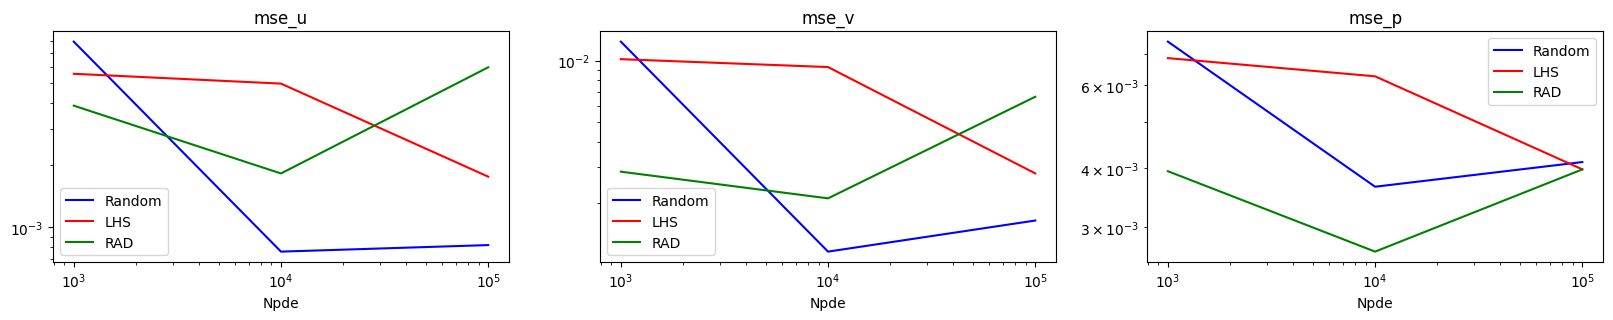

In [79]:
n_datasets
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
for i, title in enumerate(['mse_u', 'mse_v', 'mse_p']):
    ax[i].loglog([n[0] for n in n_datasets], [error[title] for error in rand_mse_error], color='blue', label='Random')
    ax[i].loglog([n[0] for n in n_datasets], [error[title] for error in lhs_mse_error], color='red', label='LHS')
    ax[i].loglog([n[0] for n in n_datasets], [error[title] for error in rad_mse_error], color='green', label='RAD')
    ax[i].set_xlabel('Npde')
    ax[i].set_title(f"{title}")
    ax[i].legend()
plt.show()

### Conclusiones

- A partir de la gráfica anterior, se observa una mejora de la norma-2 del error en función del tamaño del dataset para estregias random y LHS pero nó para estrategia RAD.

- La mejor performance de todas se obutvo con la estrategia de muestreo aleatoria con 10.000/1.000 muestras.

- Se observa que para datasets mayores a 10.000 muestras para el cálculo del residuo de la PDE y 1.000 muestras para la condición de borde no se producen mejoras notables del error.

- Al comparar las estrategias entre si, el mejor desempeño para datasets de menor tamaño fue alcanzado por la estrategia RAD. Con datasets de mayor tamaño el error conseguido con todas las estrategias se asemeja.

- Las observaciones anteriores son en parte esperables y en parte no:
    - En primer lugar era esperable que el mejor comportamiento con datasets pequeños lo tuviera la estrategia de RAD ya que elije los puntos críticos.
    - Luego, se esperaba que todas las estrategias reporten una mejora del error con el aumento del tamaño del dataset de entrenamiento al valor más grande. Una posible explicación es que a partir de determinado tamaño, se alcanza un punto crítico donde ya se tienen muestras suficientes de todas las zonas importantes y agregar más puntos deja de influir significativamente en el error obtenido.
    - Finalmente no se esperaba que el mejor error se obtuviese con estrategia aleatoria. Se estima que esto se debió a las condiciones aleatorias del experimento específico y no a bondades del método de elección de las muestras.

## TP N° 4: Resolución del problema inverso

### Muestreo ground-truth

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
n_pde = 10_000
n_bc = 1_000
xy_pde_lhs = get_xy_pde_lhs([x_lb, x_ub], [y_lb, y_ub], n_pde)
X_pde = torch.tensor(xy_pde_lhs, requires_grad = True).float().to(device)
xy_bc_lhs = get_xy_bc_lhs([x_lb, x_ub], [y_lb, y_ub], n_bc)
X_bc = torch.tensor(xy_bc_lhs).float().to(device)
X_bc_0 = torch.tensor([[0, 0]]).float().to(device)
mesh_size_list = [0.25, 0.5, 0.75]
n_mesh_size = 5

In [ ]:
def get_ds_data_mesh(pressure_ds, velocity_ds, mesh_size, n):
    x_bounds = [0.5 - mesh_size/2, 0.5 + mesh_size/2]
    y_bounds = [0.5 - mesh_size/2, 0.5 + mesh_size/2]
    x = np.linspace(x_bounds[0], x_bounds[1], n)
    y = np.linspace(y_bounds[0], y_bounds[1], n)
    xy = np.array([[x_i,y_i] for x_i in x for y_i in y])
    
    # Not all points are aligned. If a point is missing, we will find the nearest neightbor.
    xy_ds = np.concat([pressure_raw_data['x'][0][:,np.newaxis], pressure_raw_data['y'][0][:,np.newaxis]], axis = 1)
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(xy_ds)
    
    labels = []
    for idx in range(len(xy)):
        data_idx = np.argwhere(np.logical_and(pressure_ds['x'][0] == xy[idx,0], pressure_ds['y'][0] == xy[idx,1]))
        if len(data_idx) == 0:
            # Use nearest instead
            _, data_idx = nbrs.kneighbors(xy[idx:idx+1,:])
            data_idx = data_idx[0][0] 
            xy[idx, 0] = pressure_ds['x'][0][data_idx]
            xy[idx, 1] = pressure_ds['y'][0][data_idx]
        else:
            data_idx = data_idx[0][0]
        assert pressure_ds['x'][0][data_idx] == velocity_ds['x'][0][data_idx]
        assert pressure_ds['y'][0][data_idx] == velocity_ds['y'][0][data_idx]
        labels.append([velocity_ds['u'][0][data_idx], velocity_ds['v'][0][data_idx], pressure_ds['p'][0][data_idx]])
    return xy, np.array(labels)

In [ ]:
fig, ax = plt.subplots(1, len(mesh_size_list), figsize=(20, 3))
for i, mesh_size in enumerate(mesh_size_list):
    xy_data_mesh, labels_data_mesh = get_ds_data_mesh(pressure_raw_data, velocity_raw_data, mesh_size, 5)
    ax[i].scatter(xy_data_mesh[:,0], xy_data_mesh[:,1], s=4, c='r', label=f'N_data={len(xy_data_mesh)}')
    ax[i].set_xlim([-0.05, 1.05])
    ax[i].set_ylim([-0.05, 1.05])
    ax[i].set_xlabel('Space domain (x)')
    ax[i].set_ylabel('Space domain (y)')
    ax[i].set_title(f"Mesh size: {mesh_size} x {mesh_size}")
    ax[i].legend()
plt.show()

### Datos limpios

In [ ]:
# Shared model parameters
reynolds_fun = lambda x: x * torch.tanh(1e3 * x)
model_parameters = {
    "Device": device,
    "Reynolds": 100,
    "InputDimensions": 2,
    "OutputDimensions": 3,
    "NumberOfNeurons": 50,
    "NumberOfHiddenLayers": 4,
    "ActivationFunction": nn.Tanh()
}
epochs = 10000
lr = 1e-3

In [ ]:
def train_step(model, X_pde, X_bc, X_data, Y_data, Re):
    model.Reynolds = reynolds_fun(Re).to(device)
    # PDE
    output_pde = model(X_pde)
    residue_continuity, residue_momentum_x, residue_momentum_y  = model.pdeResidue(X_pde, output_pde)
    loss_pde_continuity = loss_fn(residue_continuity, torch.zeros_like(residue_continuity))
    loss_pde_momentum_x = loss_fn(residue_momentum_x, torch.zeros_like(residue_momentum_x))
    loss_pde_momentum_y = loss_fn(residue_momentum_y, torch.zeros_like(residue_momentum_y))
    loss_pde = loss_pde_continuity + loss_pde_momentum_x + loss_pde_momentum_y
    # BC
    output_bc = model(X_bc)
    residue_u, residue_v = model.bcUVResidue(X_bc, output_bc)
    loss_bc_u = loss_fn(residue_u, torch.zeros_like(residue_u))
    loss_bc_v = loss_fn(residue_v, torch.zeros_like(residue_v))
    output_bc_0 = model(X_bc_0)
    residue_p = model.bcPResidue(X_bc_0, output_bc_0)
    loss_bc_p = loss_fn(residue_p, torch.zeros_like(residue_p))
    loss_bc = 10 * (loss_bc_u + loss_bc_v) + loss_bc_p
    # Real data
    output_data = model(X_data)
    loss_data = loss_fn(output_data, Y_data)
    return loss_pde, loss_bc, loss_data

In [ ]:
print("Reynolds parameter inverse problem with clean data")

reynolds = nn.Parameter(torch.rand(1)) #Make reynolds a trainable parameter

for mesh_size in mesh_size_list:
    # Init
    model = PINN_Module(model_parameters).to(device)
    reynolds = nn.Parameter(torch.rand(1).to(device))
    init_xavier(model)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam([
        {'params': model.parameters(), 'lr': 1e-3},
        {'params': reynolds, 'lr': 0.1}], weight_decay=1e-3)

    xy_data_mesh, labels_data_mesh = get_ds_data_mesh(pressure_raw_data, velocity_raw_data, mesh_size, 5)
    X_data = torch.tensor(xy_data_mesh).float().to(device)
    Y_data = torch.tensor(labels_data_mesh).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Mesh size: {mesh_size} x {mesh_size}")
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss_pde, loss_bc, loss_data = train_step(model, X_pde, X_bc, X_data, Y_data, reynolds)
        loss_overall = loss_pde + loss_bc + loss_data
        loss_overall.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4f}, PDE: {loss_pde.item():.4f}, " 
                f"BC: {loss_bc.item():.4f}, Data: {loss_data.item():.4f} - Reynolds: {reynolds_fun(reynolds).item():.4f}")
        torch.cuda.empty_cache()

### Datos con ruido

In [ ]:
# Noise percentage
omega = 0.01

In [ ]:
print("Reynolds parameter inverse problem with noisy data")

reynolds = nn.Parameter(torch.rand(1)) #Make reynolds a trainable parameter

for mesh_size in mesh_size_list:
    # Init
    model = PINN_Module(model_parameters).to(device)
    init_xavier(model)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam([
        {'params': model.parameters(), 'lr': 1e-3},
        {'params': reynolds, 'lr': 0.1}], weight_decay=1e-3)

    xy_data_mesh, labels_data_mesh = get_ds_data_mesh(pressure_raw_data, velocity_raw_data, mesh_size, 5)
    labels_data_mesh = labels_data_mesh + \
        omega * np.max(labels_data_mesh, axis=0)[np.newaxis,:] * np.random.normal(size=(labels_data_mesh.shape))
    X_data = torch.tensor(xy_data_mesh).float().to(device)
    Y_data = torch.tensor(labels_data_mesh).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Mesh size: {mesh_size} x {mesh_size}")
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss_pde, loss_bc, loss_data = train_step(model, X_pde, X_bc, X_data, Y_data, reynolds)
        loss_overall = loss_pde + loss_bc + loss_data
        loss_overall.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4f}, PDE: {loss_pde.item():.4f}, " 
                f"BC: {loss_bc.item():.4f}, Data: {loss_data.item():.4f} - Reynolds: {reynolds_fun(reynolds).item():.4f}")
        torch.cuda.empty_cache()